#**PyTorch Paper Replicating**

**Replicating Vision Transformer** - https://arxiv.org/abs/2010.11929

In [1]:
import torch
import torchvision

In [2]:
!pip install torchinfo

### Get Helper-Function

In [3]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
!rm -rf pytorch-deep-learning

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 27.56 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


In [4]:
#Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get Data

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

## 2. Create Datasets and Dataloaders

### 2.1 Transforms

In [7]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create Image size
IMG_SIZE = 224

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f'Manuall created transforms: {manual_transforms}')

Manuall created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### 2.2 Create a batch_size of 32 and DataLoaders

In [8]:
# Create a batch_size of 32
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize the single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

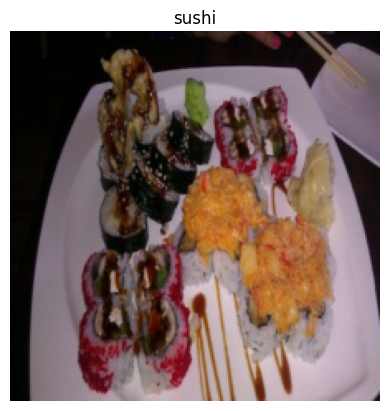

In [10]:
# Plot the image
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # -> (h, w, c)
plt.title(class_names[label])
plt.axis(False);

# 3. Replicating VIT: Overview

##1. Visualize overview of the Architecture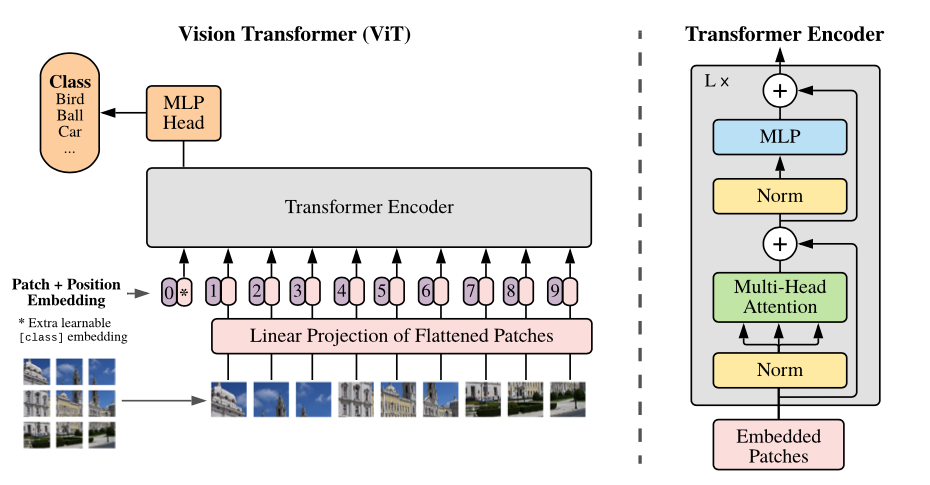

### Four Equations
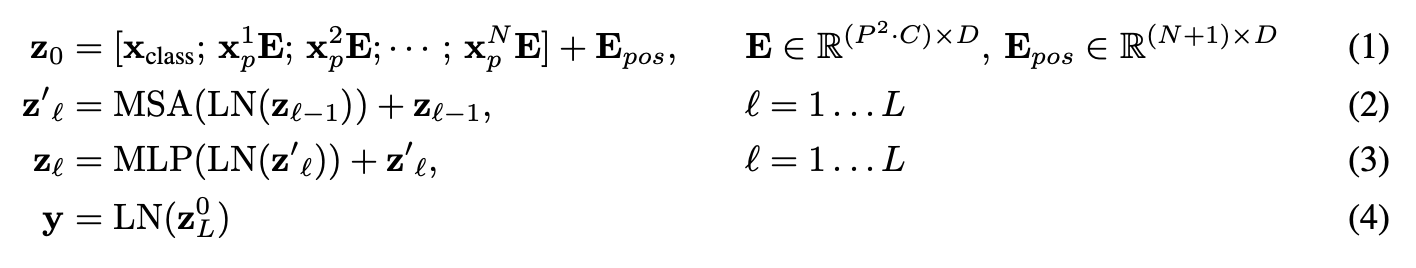

##`Equation 1 `:
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

##`Equation 1`:
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In vector form, the embedding might look something like:
`x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]`

##`Equation 2&3`:
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

##`Equation 4 `:
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

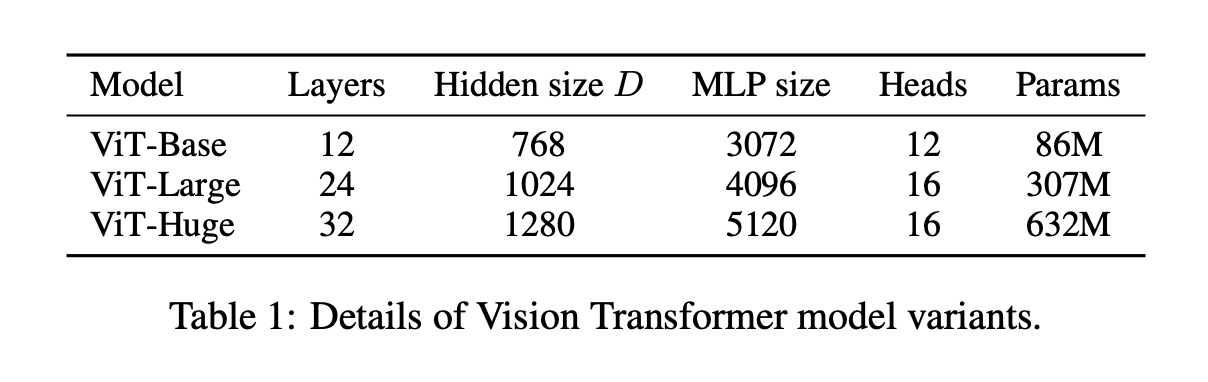

- Layers - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
- Hidden size
 - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
- MLP size - What are the number of hidden units in the MLP layers?
- Heads - How many heads are there in the Multi-Head Attention layers?
- Params - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

# 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> Function -> output

* Input Shape: ${H \times W \times C}$ (height x width x color channels)
* Output Shape: ${N \times\left(P^2 \cdot C\right)}$
* H = height
* W = width
* C = Color channels
* P = Patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension

In [11]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate no. of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
# Input Shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input_shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output_shape (single 1D sequence of patches): {embedding_layer_output_shape}')

Input_shape (single 2D image): (224, 224, 3)
Output_shape (single 1D sequence of patches): (196, 768)


## 4.2 Turning single image into patches

(-0.5, 223.5, 223.5, -0.5)

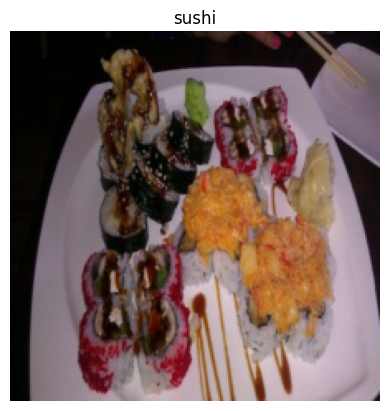

In [13]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [14]:
image.shape

torch.Size([3, 224, 224])

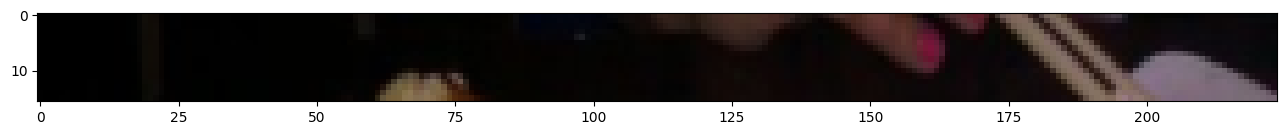

In [15]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # Converts image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch Size: 16 pixels x 16 pixels


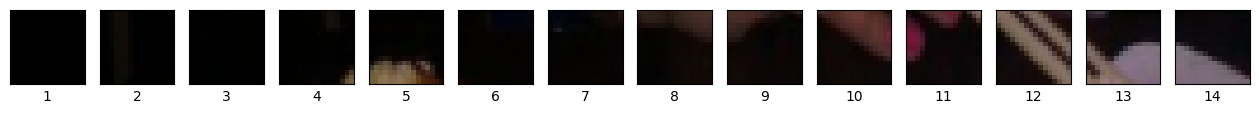

In [16]:
# plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f'Number of patches per row: {num_patches}\nPatch Size: {patch_size} pixels x {patch_size} pixels')

# Create series of subplots
fig, axs = plt.subplots(nrows = 1,
                       ncols = img_size // patch_size, # one column for each patch
                       sharex = True,
                       sharey = True,
                       figsize = (patch_size, patch_size))

# Iterate through no. of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # Set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0 
Number of patches per column: 14.0 
Total patches: 196.0 
Patch_size: 16 pixels x 16 pixels


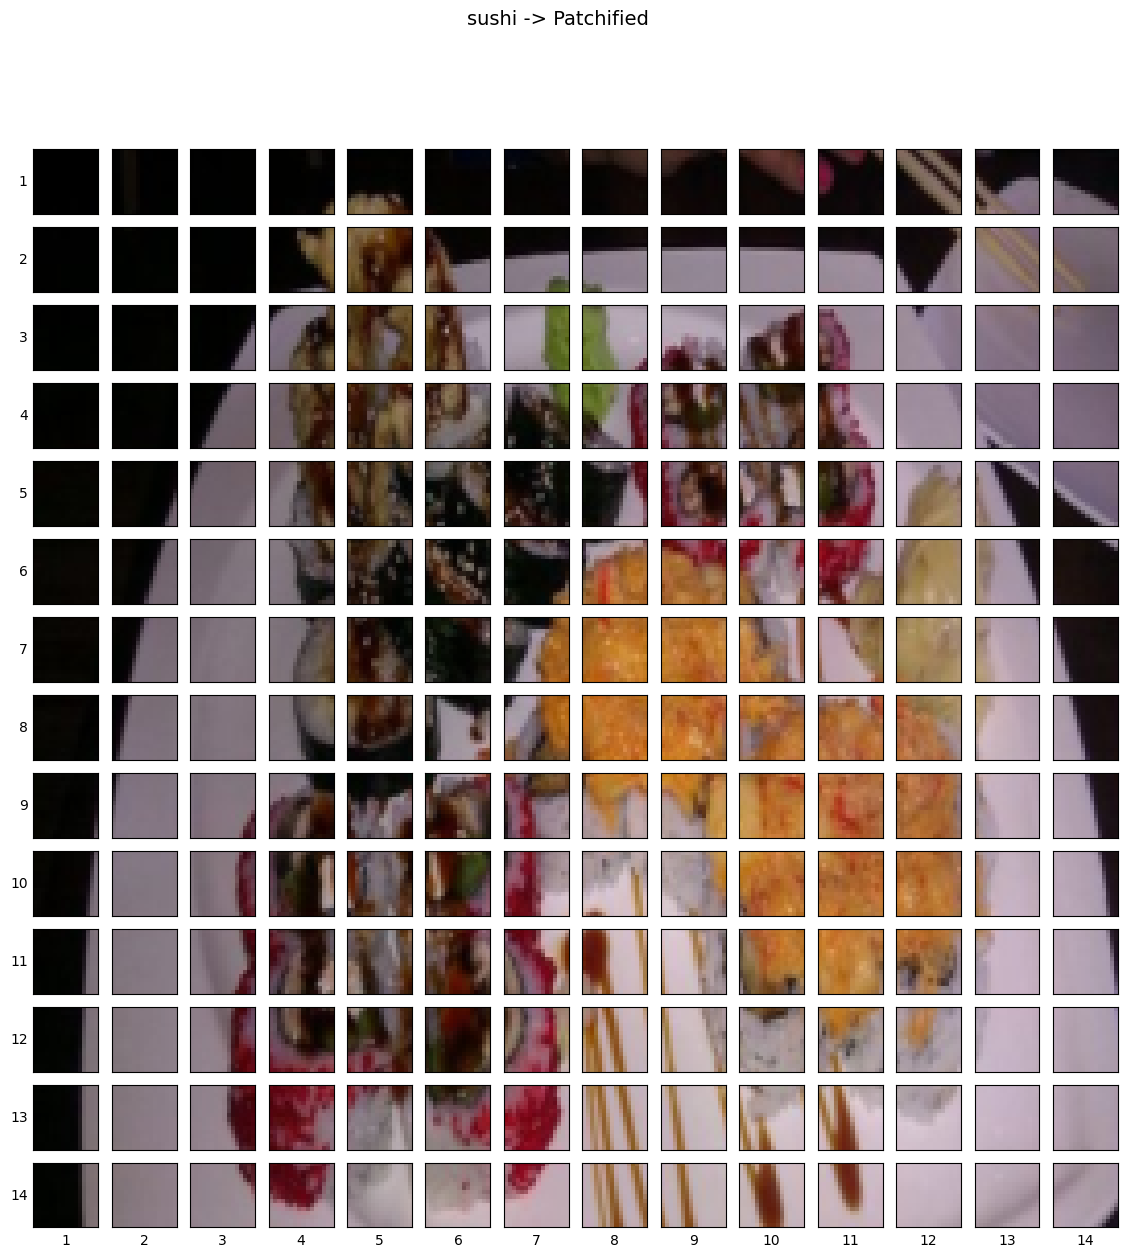

In [17]:
# Plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches} \nNumber of patches per column: {num_patches} \nTotal patches: {num_patches*num_patches} \nPatch_size: {patch_size} pixels x {patch_size} pixels')

# Create series of subplots
fig, axs = plt.subplots(nrows = img_size // patch_size,
                       ncols = img_size // patch_size,
                       figsize = (num_patches, num_patches),
                       sharex = True,
                       sharey = True)

# Loop through height & width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # Iterate through height
                                    patch_width:patch_width+patch_size, # Iterate through width
                                    :]) # get all the color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation = 'horizontal',
                         horizontalalignment = 'right',
                         verticalalignment = 'center')
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up  a title for the plot
fig.suptitle(f'{class_names[label]} -> Patchified', fontsize = 14)
plt.show()

## 4.2 Creating Image Patches and turning them into patch embeddings

In [18]:
# Create Conv2D layer to turn image into patch of learnable feature maps (embedding)
from torch import nn

# patch size
patch_size = 16

# Create conv2D layer with hyperparameter from the ViT paper
conv2d = nn.Conv2d(in_channels = 3, # For color images
                   out_channels = 768, # # D size from Table 1
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

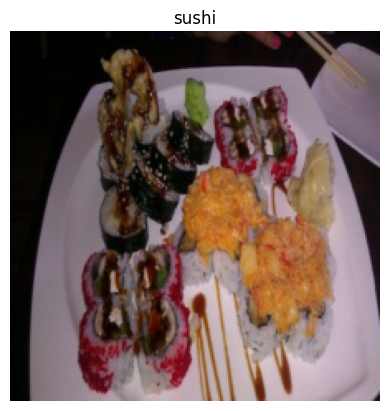

In [19]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [20]:
# Pass image through Convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


### **`torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]`**

In [21]:
image_out_of_conv.requires_grad

True

Showing Random Convolutional feature maps from indexex: [684, 198, 362, 302, 724]


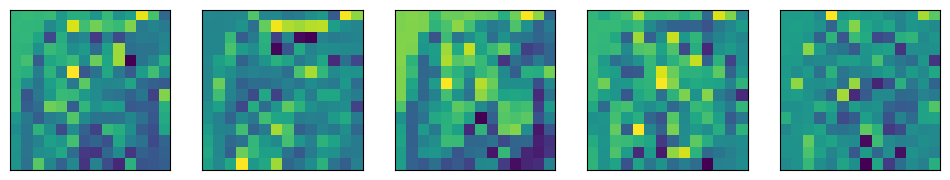

In [22]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f'Showing Random Convolutional feature maps from indexex: {random_indexes}')

# Create plot
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]  # Index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Remove batch dimension, and remove from grad tracking / switch to numpy
  axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

In [23]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-2.1183e-02, -2.9121e-02, -2.2312e-02, -4.9802e-03, -8.2194e-02,
           -4.0897e-02, -4.1745e-02, -5.1969e-02, -6.2843e-02, -1.0363e-01,
           -8.9153e-02, -1.8928e-01, -3.8542e-02, -1.3992e-01],
          [-2.1082e-02, -2.0554e-02, -2.6525e-02, -4.7997e-02, -1.4649e-01,
           -7.9797e-02, -2.4906e-01, -1.8794e-01, -2.0616e-01, -2.0742e-01,
           -1.5769e-01, -2.9752e-02, -3.2027e-01, -3.1484e-01],
          [-2.1650e-02, -2.1763e-02,  9.3376e-02, -3.2201e-01, -2.2522e-01,
           -1.1033e-01, -4.7056e-01, -4.4575e-01, -4.3316e-01, -3.1094e-01,
           -2.6945e-01, -3.7691e-01, -3.2622e-01, -2.8508e-01],
          [-2.0697e-02, -2.4757e-02, -1.9678e-02, -1.6624e-01, -1.4384e-01,
           -2.7508e-01, -1.2299e-01, -3.2768e-01, -1.1639e-01, -2.9959e-01,
           -1.7602e-01, -4.0727e-01, -3.2796e-01, -3.0725e-01],
          [-2.8153e-02,  3.5757e-02, -2.8803e-01, -2.9355e-01, -1.1729e-01,
           -1.3798e-01, -7.9994e-02, -8.5181e-03, -2.5919e-0

## 4.4 Flattening the patch embedding with `torch.nn.Flatten`

In [24]:
print(f'{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)')

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [25]:
flatten_layer = nn.Flatten(start_dim = 2,
                           end_dim = 3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original Image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


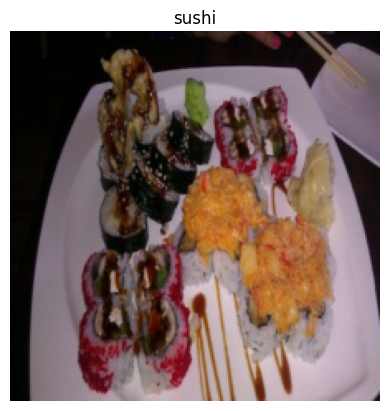

In [26]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original Image shape: {image.shape}')

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')

In [27]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f'{image_out_of_conv_flattened_permuted.shape} --> (batch_size, numper_of_patches, embedding_dimension)')

torch.Size([1, 196, 768]) --> (batch_size, numper_of_patches, embedding_dimension)


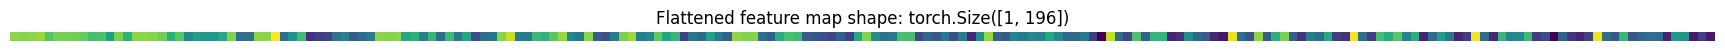

In [28]:
# Get a single flattened featured map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize = (22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False);

## 4.5 Turning the ViT patch embedding layer into a PyTorch Module

In [29]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 16,
               embedding_dim:int = 768): # from Table 1 for ViT base
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)
    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)

  # 5. Define the forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image size must be divisible by patch_size, image_shape: {image_resolution}, patch size: {self.patch_size}'


    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure returned sequence embedding dimensions are in the right order (batch_size, no_of_patches, embedding_dimensions)
    return x_flattened.permute(0, 2, 1)

In [30]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim = 768)

# pass a single image through patch embedding layer
print(f'Input image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0)) # Add an extra batch dimension
print(f'Output of patch embeddeding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output of patch embeddeding sequence shape: torch.Size([1, 196, 768])


In [31]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class token embedding

In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [33]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [34]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim = 1) # No. of patches dimension
print(patch_embedded_image_with_class_embedding)
print(f'Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0181, -0.0107, -0.0320,  ...,  0.0109, -0.0027,  0.0024],
         [-0.0473, -0.0192, -0.0455,  ...,  0.0247,  0.0097,  0.0331],
         ...,
         [-0.7496,  0.1824, -0.1860,  ...,  0.5723, -0.3723,  0.2723],
         [-0.7189,  0.1585, -0.1278,  ...,  0.4828, -0.3453,  0.2607],
         [-0.4600,  0.1816, -0.2139,  ...,  0.4699, -0.3123,  0.1657]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating a position embedding

In [35]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0181, -0.0107, -0.0320,  ...,  0.0109, -0.0027,  0.0024],
          [-0.0473, -0.0192, -0.0455,  ...,  0.0247,  0.0097,  0.0331],
          ...,
          [-0.7496,  0.1824, -0.1860,  ...,  0.5723, -0.3723,  0.2723],
          [-0.7189,  0.1585, -0.1278,  ...,  0.4828, -0.3453,  0.2607],
          [-0.4600,  0.1816, -0.2139,  ...,  0.4699, -0.3123,  0.1657]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [36]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size ** 2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create 1D learnable position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension))
position_embedding.shape

torch.Size([1, 197, 768])

In [37]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9819, 0.9893, 0.9680,  ..., 1.0109, 0.9973, 1.0024],
         [0.9527, 0.9808, 0.9545,  ..., 1.0247, 1.0097, 1.0331],
         ...,
         [0.2504, 1.1824, 0.8140,  ..., 1.5723, 0.6277, 1.2723],
         [0.2811, 1.1585, 0.8722,  ..., 1.4828, 0.6547, 1.2607],
         [0.5400, 1.1816, 0.7861,  ..., 1.4699, 0.6877, 1.1657]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

In [38]:
set_seeds(42)

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of original image and get the image dimension
print(f'Image Tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f'Patch Embedding shape: {patch_embedding.shape}')

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
print(f'Class token embedding shape: {class_token.shape}')

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f'Patch Embedding with class token shape: {patch_embedding_class_token.shape}')

# 8. Create Position embedding
number_of_patches = int((height * width) // patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad = True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image Tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch Embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch Embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# 5. Equation 2: Multi-Head Attention (MSA)

We've got our input data patchified and embedded, now let's move onto the next part of the ViT architecture.

To start, we'll break down the Transformer Encoder section into two parts (start small and increase when necessary).

The first being equation 2 and the second being equation 3.

Recall equation 2 states:

 \begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

In [39]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Creates a multi-head self attention block ('MSA block' for short).
  """
  def __init__(self, embedding_dim: int = 768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads: int = 12, # Heads from Table 1 for ViT-Base
               attn_dropout: int = 0):
    super().__init__()

    # Create the Norm Layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # Create the Multihead attention layer (MSA)
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x,
                                        key = x,
                                        value = x,
                                        need_weights = False)
    return attn_output

In [40]:
# Create an instance MSA Block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim = 768,
                                                             num_heads = 12,
                                                             attn_dropout = 0)

# Pass the patch and position image embedding sequence throught MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output Shape of MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Output Shape of MSA block: torch.Size([1, 197, 768])


In [41]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9819, 0.9893, 0.9680,  ..., 1.0109, 0.9973, 1.0024],
         [0.9527, 0.9808, 0.9545,  ..., 1.0247, 1.0097, 1.0331],
         ...,
         [0.2504, 1.1824, 0.8140,  ..., 1.5723, 0.6277, 1.2723],
         [0.2811, 1.1585, 0.8722,  ..., 1.4828, 0.6547, 1.2607],
         [0.5400, 1.1816, 0.7861,  ..., 1.4699, 0.6877, 1.1657]]],
       grad_fn=<AddBackward0>)

In [42]:
patched_image_through_msa_block

tensor([[[-0.1741, -0.1511,  0.0902,  ..., -0.4017,  0.8038, -0.4672],
         [-0.1872, -0.1719,  0.0919,  ..., -0.3743,  0.7944, -0.4528],
         [-0.1561, -0.1605,  0.1067,  ..., -0.3739,  0.8039, -0.4438],
         ...,
         [-0.1272, -0.1370,  0.0886,  ..., -0.3765,  0.8085, -0.4829],
         [-0.1270, -0.1357,  0.0878,  ..., -0.3747,  0.8075, -0.4797],
         [-0.1271, -0.1393,  0.0891,  ..., -0.3844,  0.8110, -0.4904]]],
       grad_fn=<TransposeBackward0>)

# 6. Equation 3: Multilayer Perceptron (MLP)

\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

And the addition on the end is the skip/residual connection.

We'll refer to equation 3 as the "MLP block" of the Transformer encoder (notice how we're continuing the trend of breaking down the architecture into smaller chunks).

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

In [43]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: int = 0.1):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(p = dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x


In [44]:
# Create an instance of MLP Block
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP Block: {patched_image_through_msa_block.shape}')
print(f'Output shape of MSA Block: {patched_image_through_mlp_block.shape}')

Input shape of MLP Block: torch.Size([1, 197, 768])
Output shape of MSA Block: torch.Size([1, 197, 768])


# 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (eq 2) and MLP (eq 3).

and there are residual connections between each block

* Encoder = turn a sequence into learnable representation.
* Decoder = go from learn representation back to some sort of sequence.
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (Prevent weights from getting small)

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transformer Encoder Block

In [45]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: int = 0.1,
               attn_dropout: int = 0):
    super().__init__()

    # Create MSA Block (eq 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    # Create MLP Block (eq 3)
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual / Skip connection for equation 2
    x = self.mlp_block(x) + x # residual / skip connection for equation 3
    return x

In [46]:
from torchinfo import summary

In [47]:
# Create an instance of TransfomerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model = transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder Layer with in-built PyTorch Layers

In [48]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                             nhead = 12,
                                                             dim_feedforward = 3072,
                                                             dropout = 0.1,
                                                             activation = 'gelu',
                                                             batch_first = True,
                                                             norm_first = True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [49]:
summary(model = torch_transformer_encoder_layer,
        input_size = (1, 197, 768),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# 8. Putting it all together to create ViT

In [50]:
# Create ViT Class
class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224,
               in_channels: int = 3,
               patch_size: int = 16,
               num_transformer_layer: int = 12,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               num_heads: int = 12,
               attn_dropout: int = 0,
               mlp_dropout: int = 0.1,
               embedding_dropout: int = 0.1,
               num_classes = 1000):
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0, f'Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}'

    # Calculate the number of patches (height * width / patch ^ 2)
    self.num_patches = (img_size * img_size) // patch_size ** 2

    # Create learnable class embedding
    self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                        requires_grad = True)

    # Create learning position embedding
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches + 1, embedding_dim))

    # Create a embedding dropout values
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

    # Create the Transformer Encoder Block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim = embedding_dim,
                                                                       num_heads = num_heads,
                                                                       mlp_size = mlp_size,
                                                                       mlp_dropout = mlp_dropout) for _ in range(num_transformer_layer)])

    # Create Classifier Head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match and batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # Create the patch embedding  (equation 1)
    x = self.patch_embedding(x)

    # Concat class_token embedding and patch_embedding (equation 1)
    x = torch.cat((class_token, x), dim = 1)

    # Add position embedding to class_token and patch_embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to TransformerEncoder
    x = self.transformer_encoder(x)

    # Put the 0th index logit through classifier(equation 4)
    x = self.classifier(x[:,0])

    return x

In [51]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [52]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes (pizza, steak and sushi)
vit = ViT(num_classes = len(class_names))

# pass the random_image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [53]:
from torchinfo import summary

summary(model = ViT(num_classes = len(class_names)),
        input_size = (1, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

# 9. Setting up training code for custom ViT

### 9.1 Create an Optimizer

### 9.2 Create Loss Function

### 9.3 Training our ViT Model

In [54]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(vit.parameters(),
                             lr = 1e-3,
                             betas = (0.9, 0.999),
                             weight_decay = 0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       epochs = 10,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6697 | train_acc: 0.3086 | test_loss: 1.2545 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3203 | test_loss: 1.0593 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.3925 | train_acc: 0.4219 | test_loss: 1.3158 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2488 | train_acc: 0.4219 | test_loss: 2.3024 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.5335 | train_acc: 0.2852 | test_loss: 1.9660 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.5853 | train_acc: 0.3164 | test_loss: 1.2593 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.3238 | train_acc: 0.4375 | test_loss: 1.1766 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2108 | train_acc: 0.2617 | test_loss: 1.9692 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.5777 | train_acc: 0.2891 | test_loss: 1.4056 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1396 | train_acc: 0.4219 | test_loss: 1.1256 | test_acc: 0.5417


### 9.4 What our training setup is missing

The original ViT architecture achieves good results on several image classification benchmarks (on par or better than many state-of-the-art results when it was released).

However, our results (so far) aren't as good.

There's a few reasons this could be but the main one is scale.

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule

**Prevent Underfitting:**
* Data - our setup uses far less data (225 vs millions)

**Prevent Overfitting:**
* Learning rate warmup - start with a low learning rate and increase to a base LR.
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate.
* Gradient Clipping - prevents gradient from getting too big.

### 9.5 Plotting loss curves for our model

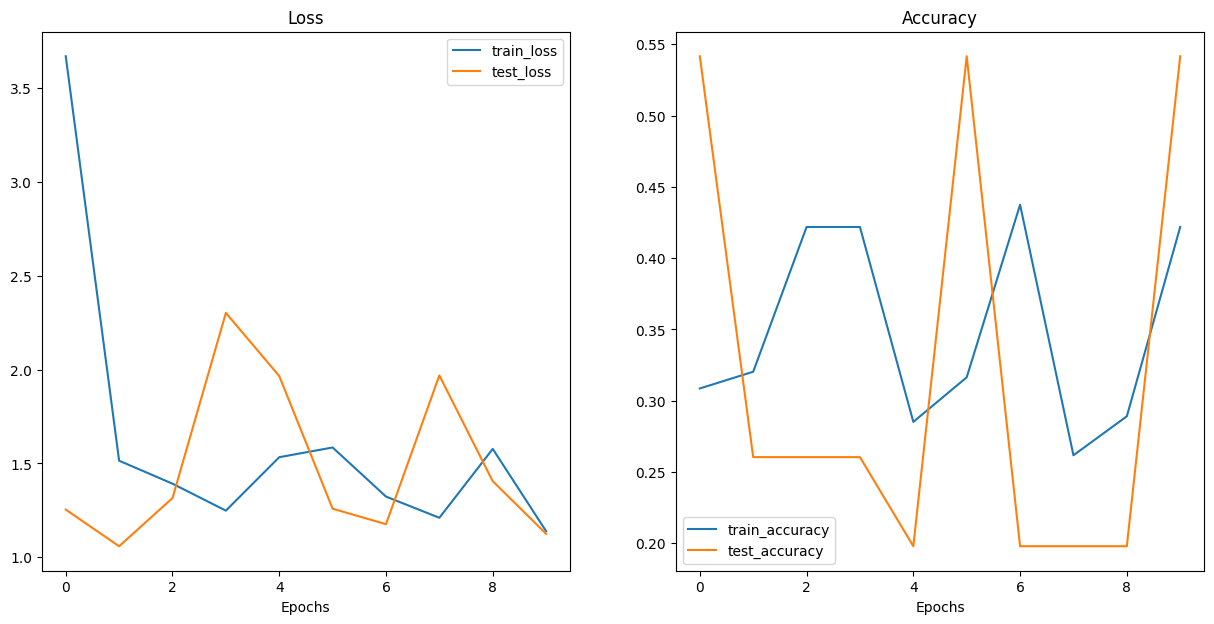

In [55]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

# 10. Using a pre-trained ViT from `torchvision.models`

### 10.1 Pretrained Model and Feature Extractor

In [60]:
# Get Pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # Default = Best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features = 768, out_features=len(class_names)).to(device)

In [61]:
summary(model = pretrained_vit,
        input_size = (1, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.2 Preparing data for Pretrained Model

In [62]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [65]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                     test_dir = test_dir,
                                                                                                     transform = vit_transforms,
                                                                                                     batch_size = 32)

In [67]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x790691400a30>,
 <torch.utils.data.dataloader.DataLoader at 0x7905b24e2170>)

### 10.3 Train Feature extractor ViT model

In [68]:
from going_modular.going_modular import engine

# Create Optimizer and loss function
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head or pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model = pretrained_vit,
                                      train_dataloader = train_dataloader_pretrained,
                                      test_dataloader = test_dataloader_pretrained,
                                      optimizer = optimizer,
                                      loss_fn = loss_fn,
                                      epochs = 10,
                                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model


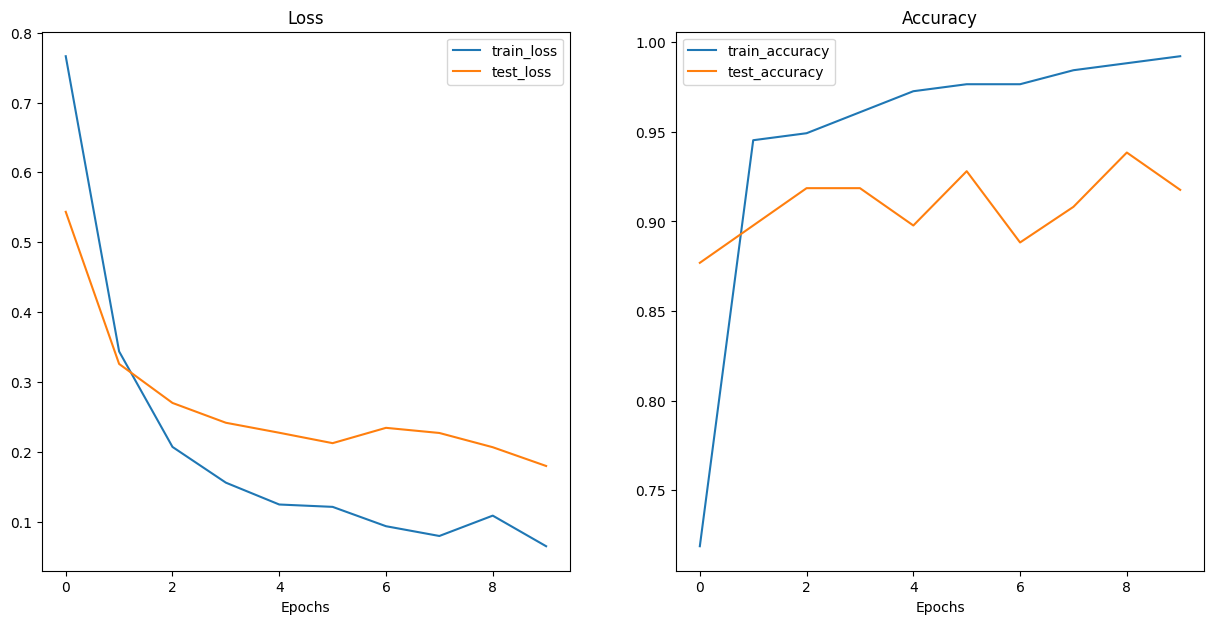

In [69]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

### 10.5 Save our best performing ViT model

In [70]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model = pretrained_vit,
                 target_dir = 'models',
                 model_name = 'Pretrained_ViT_Feature_extractor.pth')

[INFO] Saving model to: models/Pretrained_ViT_Feature_extractor.pth


In [73]:
from pathlib import Path

# Get the model size in bytes then convert to MegaBytes
pretrained_vit_model_size = Path('/content/models/Pretrained_ViT_Feature_extractor.pth').stat().st_size // (1024 * 1024)
print(f'Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB')

Pretrained ViT feature extractor model size: 327 MB


# 11. Predicting on Custom Image

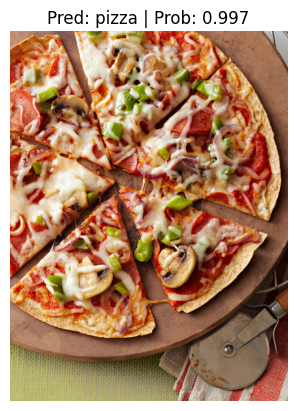

In [74]:
# Predict on custom image
from going_modular.going_modular.predictions import pred_and_plot_image

pred_and_plot_image(model = pretrained_vit,
                    image_path = '/content/pizza.jpg',
                    class_names = class_names)

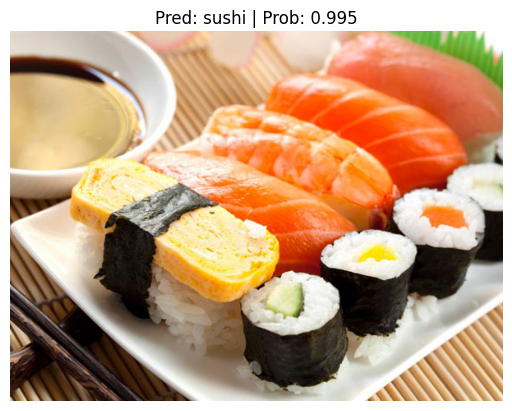

In [75]:
pred_and_plot_image(model = pretrained_vit,
                    image_path = '/content/Sushi-1-1.jpg',
                    class_names = class_names)

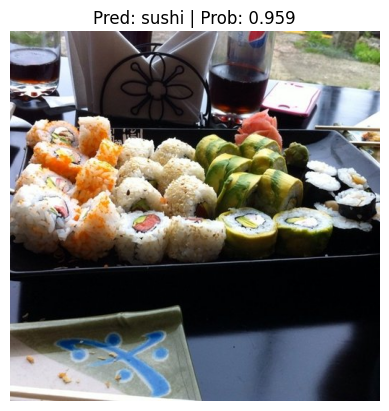

In [76]:
pred_and_plot_image(model = pretrained_vit,
                    image_path = '/content/data/pizza_steak_sushi/test/sushi/1434806.jpg',
                    class_names = class_names)

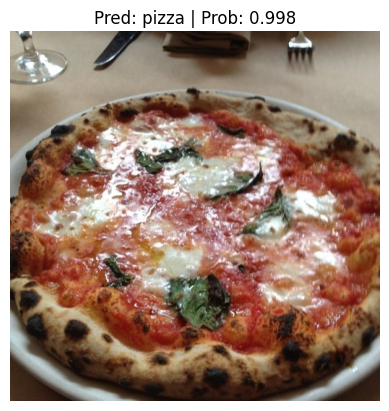

In [77]:
pred_and_plot_image(model = pretrained_vit,
                    image_path = '/content/data/pizza_steak_sushi/test/pizza/1687143.jpg',
                    class_names = class_names)